In [20]:
import eznf
import numpy as np
import cupy as cpy
from tqdm import tqdm
from eznf import optim
from eznf import Tensor
from eznf import datasets
from eznf import visualization

### 全连接神经网络

In [21]:
class MLP(eznf.nn.Module):
    def __init__(self):
        super().__init__()
        self.networks = [
            eznf.nn.Linear(784, 256),
            eznf.nn.ReLU(),
            eznf.nn.Linear(256, 10)
        ]
    
    def forward(self, x):
        for i in self.networks:
            x = i(x)
        return x

### 卷积神经网络

In [22]:
class CNN(eznf.nn.Module):
    def __init__(self):
        super().__init__()
        self.networks = [
            eznf.nn.Cov2d(1, 3, 3),
            eznf.nn.MaxPooling(2),
            eznf.nn.Flatten(),
            eznf.nn.Linear(507, 256),
            eznf.nn.ReLU(),
            eznf.nn.Linear(256, 10)
        ]
    
    def forward(self, x):
        for i in self.networks:
            x = i(x)
        return x

### 数据读取

In [23]:
mnist = datasets.MNIST('./', False)
data = mnist.get()

### 数据预处理

In [24]:
MLP_X_train, MLP_Y_train, MLP_X_test, MLP_Y_test = data

MLP_X_train = MLP_X_train / 255
MLP_X_train = np.vstack([i.flatten() for i in MLP_X_train.item])
MLP_X_train = Tensor(MLP_X_train)

MLP_X_test = MLP_X_test / 255
MLP_X_test = np.vstack([i.flatten() for i in MLP_X_test.item])
MLP_X_test = Tensor(MLP_X_test)

MLP_Y_train = eznf.one_hot(Tensor(MLP_Y_train), 10)
MLP_Y_test = eznf.one_hot(Tensor(MLP_Y_test), 10)

In [25]:
CNN_X_train, CNN_Y_train, CNN_X_test, CNN_Y_test = data

CNN_X_train = CNN_X_train / 255
CNN_X_train = eznf.Tensor(CNN_X_train, requires_grad=False)
CNN_X_train = CNN_X_train[:,None,:,:]

CNN_X_test = CNN_X_test / 255
CNN_X_test = eznf.Tensor(CNN_X_test, requires_grad=False)
CNN_X_test = CNN_X_test[:,None,:,:]

CNN_Y_train = eznf.one_hot(Tensor(CNN_Y_train), 10)
CNN_Y_test = eznf.one_hot(Tensor(CNN_Y_test), 10)

### MLP训练

In [26]:
epoches = 100
batch_size = 1024
steps = len(MLP_X_train) // batch_size

mlp = MLP()
loss = eznf.nn.CrossEntropyLoss()
opt = optim.SGD(alpha=0.01, model=mlp)

with tqdm(total=epoches) as t:
    for i in range(epoches):
        for j in range(steps):
            x = MLP_X_train[j*batch_size : (j+1)*batch_size]
            y = MLP_Y_train[j*batch_size : (j+1)*batch_size]
            out = mlp(x.T)
            l = loss(out, y.T) / batch_size
            l.backward()
            opt.step()
            opt.zero_grad()
        
        t.set_description('Epoch {}'.format(i), refresh=False)
        t.set_postfix(loss=l.item[0], refresh=False)
        t.update(1)

Epoch 99: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s, loss=0.143]


e:\QQDownload\神经网络课程设计\代码\eznf\visualization\Evaluation.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  img.show()


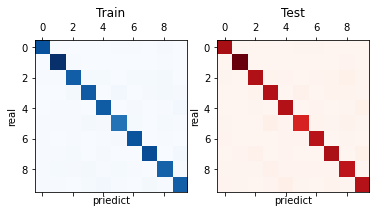

In [27]:
v=visualization.Evaluation(mlp, MLP_X_train.T, MLP_X_test.T, MLP_Y_train, MLP_Y_test, 10)
v.CMplot()

### CNN训练

In [28]:
epoches = 20
batch_size = 1024
steps = len(CNN_X_train) // batch_size

cnn = CNN()
loss = eznf.nn.CrossEntropyLoss()
opt = optim.SGD(alpha=0.01, model=cnn)

with tqdm(total=epoches) as t:
    for i in range(epoches):
        for j in range(steps):
            x = CNN_X_train[j*batch_size : (j+1)*batch_size]
            y = CNN_Y_train[j*batch_size : (j+1)*batch_size]
            out = cnn(x)
            l = loss(out, y.T) / batch_size
            l.backward()
            opt.step()
            opt.zero_grad()
        
        t.set_description('Epoch {}'.format(i), refresh=False)
        t.set_postfix(loss=l.item[0], refresh=False)
        t.update(1)

Epoch 19: 100%|██████████| 20/20 [03:39<00:00, 10.98s/it, loss=1.83]


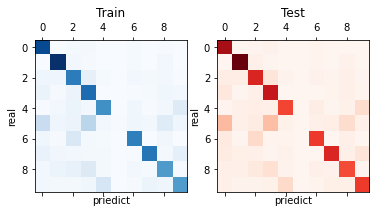

In [29]:
v=visualization.Evaluation(cnn, CNN_X_train, CNN_X_test, CNN_Y_train, CNN_Y_test, 10)
v.CMplot()

### GPU测试

In [30]:
from time import time

a = eznf.ones(1000, 1000)
t1 = time()
for i in range(100):
    b  = a @ a
print('CPU: ', time() - t1)

a.to('gpu')
t1 = time()
for i in range(100):
    b  = a @ a
print('GPU: ', time() - t1)

CPU:  2.4389991760253906
GPU:  1.502063512802124


### 感知机测试

In [31]:
#数据集准备
train_X = eznf.Tensor([[1.,-1.,-1.],[1.,1.,-1.]])
test_X = eznf.Tensor([1.,1.,-1.])
train_Y = eznf.Tensor([1.,-1.])
test_Y = eznf.Tensor([1.])

#参数设置
lr = 0.5
max_step = 100

p_model = eznf.nn.Perceptron(lr,max_step)
p_model.fit(train_X,train_Y)

print(f"test_Y = {test_Y},pred_Y = {p_model.predict(test_X)}")

AttributeError: module 'eznf.nn' has no attribute 'Perceptron'

### Hebb测试

In [ ]:
#数据集准备
train_X = eznf.Tensor([[1.,-1.,-1.],[1.,1.,-1.]])
test_X = eznf.Tensor([-1.,1.,-1.])
train_Y = eznf.Tensor([1.,-1.])
test_Y = eznf.Tensor([1.])

#参数设置
lr = 0.5

h_model = eznf.nn.Hebb(lr)
h_model.fit(train_X,train_Y)

print(f"test_Y = {test_Y},pred_Y = {h_model.forward(test_X)}")

In [32]:
tensor = eznf.Tensor(2, 4)
print(tensor)

tensor(
[[ 1.30387739 -1.1998284   1.47868658  0.46624838]
 [-0.56039362 -1.57864911 -0.9321185  -0.69342469]]
)
